# Will there be Enough Snow in the 2018 and 2022 Winter Olympics?

In this Notebook we will analyze temperature and snow depth in the upcoming Winter Olympics locations - South Korea,  __[PyeongChang 2018](https://en.wikipedia.org/wiki/2018_Winter_Olympics)__  and China, __[Beijing 2022](https://en.wikipedia.org/wiki/2020_Summer_Olympics)__.

PyeongChang is located in a temperate continental climate area with rainfall throughout the year. However, the Olympics are held in February which is one of the driest months in PyeongChang. __[Beijing](https://en.wikipedia.org/wiki/Beijing#Climate)__ at the same time has high humidity mostly during summertime due to the East Asian monsoon, and colder, direr and windier winters influenced by the Siberian anticyclone.


For making these analyses we added __[NCEP Climate Forecast System Reanalysis (CFSR)](http://data.planetos.com/datasets/ncep_cfsr_global_03)__ dataset to the __[Planet OS Datahub](http://data.planetos.com/)__. CFSR has 69 variables including temperature, soil data, pressure, wind components and so on, and it covers several decades — from 1979 to 2010. It’s a global, high resolution, coupled atmosphere-ocean-land surface-sea ice system designed to provide the best estimate of the state of these coupled domains.

In this demo we will be using two variables, _surface temperature_ and _temperature at 2m height_ to analyze the snow conditions in PyeongChang and Beijing. 

So, we will do the following:

1) use the Planet OS package API to fetch data;

2) will see average temperatures in January;

3) will plot average snow depth in February;

4) find out on how many days in January temperatures were below -3.5 C.


In [1]:
%matplotlib inline
import numpy as np
from dh_py_access import package_api
import dh_py_access.lib.datahub as datahub
import xarray as xr
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from po_data_process import comparison_bar_chart, make_comparison_plot
import warnings
warnings.filterwarnings("ignore")

<font color='red'>Please put your datahub API key into a file called APIKEY and place it to the notebook folder or assign your API key directly to the variable API_key!</font>

In [2]:
server = 'api.planetos.com'
API_key = open('APIKEY').readlines()[0].strip() #'<YOUR API KEY HERE>'
version = 'v1'

At first, we need to define the dataset name and variables we want to use.

In [3]:
dh=datahub.datahub(server,version,API_key)
dataset='ncep_cfsr_global_03'
variable_names = 'Temperature_height_above_ground,Snow_depth_surface'
time_start = '1979-01-01T00:00:00'
time_end = '2010-12-31T23:00:00'

For the start, let's see where exactly PyeongChang (green) and Beijing (orange) are located.

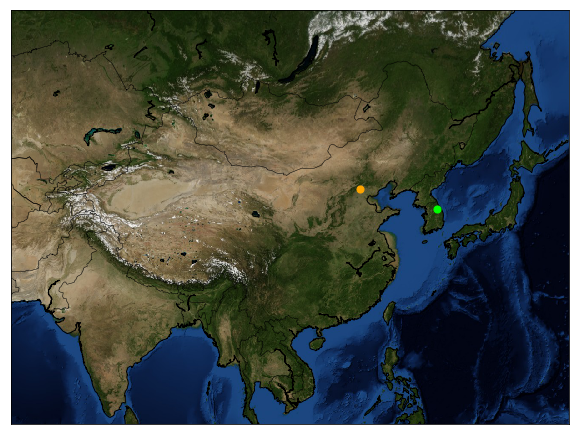

In [4]:
plt.figure(figsize=(10,8))
m = Basemap(projection='merc',llcrnrlat=7,urcrnrlat=58,\
            llcrnrlon=62,urcrnrlon=149,lat_ts=20,resolution='l')
x,y = m(128.47,37.55)
x2,y2 = m(116.39,39.99)
m.drawcoastlines()
m.drawcountries()
m.bluemarble()
m.scatter(x,y,50,marker='o',color='#00FF00',zorder=4)
m.scatter(x2,y2,50,marker='o',color='orange',zorder=4)
plt.show()

We are selecting the Gangwon province area in South Korea, where the PyeongChang 2018 Winter Olympics is taking place.

In [5]:
area_name1 = 'PyeongChang'
latitude_north1 = 37.79; longitude_west1 = 128.76
latitude_south1 = 37.20; longitude_east1 = 127.54

At the same time, we are also selecting Beijing, Zhangjiakou and Yanqing in China where the Beijing 2022 Winter Olympics will be taking place. 

In [6]:
area_name2 = 'Beijing'
latitude_north2 = 41.12; longitude_west2 = 114.46
latitude_south2 = 39.56; longitude_east2 = 116.93

### Download the data with package API

1. Create package objects
2. Send commands for the package creation
3. Download the package files

In [7]:
package1 = package_api.package_api(dh,dataset,variable_names,longitude_west1,longitude_east1,latitude_south1,latitude_north1,time_start,time_end,area_name=area_name1)
package2 = package_api.package_api(dh,dataset,variable_names,longitude_west2,longitude_east2,latitude_south2,latitude_north2,time_start,time_end,area_name=area_name2)

In [8]:
package1.make_package()
package2.make_package()

package1.make_package()
package2.make_package()

In [9]:
package1.download_package()
package2.download_package()

### Work with downloaded files

To evaluate the snow conditions we start by looking into snow depth. We start by opening the files with xarray and by making data column Temp_celsius where we have temperature data in Celsius, as they are in Kelvins at first. 

In [10]:
dd1 = xr.open_dataset(package1.local_file_name,decode_cf=False)
del (dd1['Temperature_height_above_ground'].attrs['missing_value'])
del (dd1['Snow_depth_surface'].attrs['missing_value'])
dd1 = xr.conventions.decode_cf(dd1)
dd1['Temp_celsius'] = dd1.Temperature_height_above_ground
dd1['Temp_celsius'].values = dd1['Temp_celsius'].values -272.15
dd1['Temp_celsius'].attrs['units'] = 'Celsius'

dd2 = xr.open_dataset(package2.local_file_name,decode_cf=False)
del (dd2['Temperature_height_above_ground'].attrs['missing_value'])
del (dd2['Snow_depth_surface'].attrs['missing_value'])
dd2 = xr.conventions.decode_cf(dd2)
dd2['Temp_celsius'] = dd2.Temperature_height_above_ground
dd2['Temp_celsius'].values = dd2['Temp_celsius'].values -272.15
dd2['Temp_celsius'].attrs['units'] = 'Celsius'


So, we are going to look into snow depth in February, when the Olympic Games take place. First we will filter out values from February and calculate the mean values.

In [11]:
i_snow = np.where(dd1.Snow_depth_surface['time.month'].values == 2)
feb_mean_snow1 = dd1.Snow_depth_surface[i_snow].resample('1AS', dim='time', how='mean').mean(axis=(1,2))
feb_mean_snow2 = dd2.Snow_depth_surface[i_snow].resample('1AS', dim='time', how='mean').mean(axis=(1,2))

From the plot below we can see that both of the places have snow during February. However, the snow cover tends to be quite low, usually less than 10 cm. Even less for Beijing, where the average snow depth in February is 0.016 meters, while in PyeongChang it is around 0.034 meters.

This means that both of the cities need to produce massive amounts of artificial snow in advance to meet the necessary conditions of the Winter Olympic Games. They will need to start making snow in early January. Producing artificial snow requires quite specific weather conditions of which the most critical one is the temperature. There has to be at least -3,5 degrees Celsius cold or more to successfully make snow.

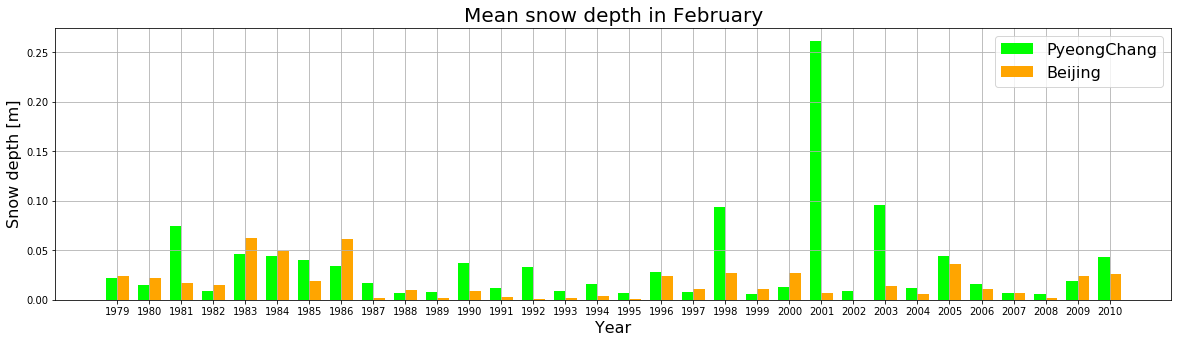

In [12]:
comparison_bar_chart(feb_mean_snow1,area_name1, feb_mean_snow2,area_name2,'Year', np.arange(1979,2011,1),'Snow depth [m]','Mean snow depth in February')

In [13]:
print ('Overall average snow cover in PyeongChang in February is ' + str("%.3f" % np.mean(feb_mean_snow1.values)) + ' m')
print ('Overall average snow cover in Beijing in February is ' + str("%.3f" % np.mean(feb_mean_snow2.values)) + ' m')

Overall average snow cover in PyeongChang in February is 0.034 m
Overall average snow cover in Beijing in February is 0.017 m


Fortunately, after we plotted the mean temperature data for January, we discovered that that even though both of the locations fail to meet the natural snow conditions, they at least have quite constantly cold air to enable artificial snowmaking. Beijing tends to have a bit colder degrees than PyeongChang, on average -9.72 C, while in PyeongChang it is -6.20 C.

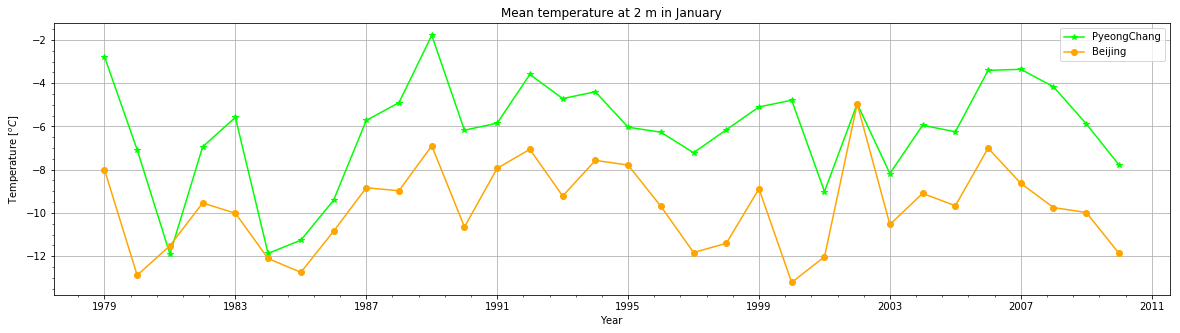

In [14]:
i = np.where(dd1.Temp_celsius['time1.month'].values == 1)
#make_comparison_plot(data1,area_name1,data2,area_name2,title,**kwargs)
make_comparison_plot(dd1.Temp_celsius[i].resample('1AS', dim='time1', how='mean').mean(axis=(1,2,3)),area_name1, dd2.Temp_celsius[i].resample('1AS', dim='time1', how='mean').mean(axis=(1,2,3)),area_name2,'Mean temperature at 2 m in January',xaxis_label = 'Year',yaxis_label = 'Temperature [$^oC$]')

In [15]:
print ('Overall mean temperature in PyeongChang in February ' + str("%.2f" % dd1.Temp_celsius[i].resample('1AS', dim='time1', how='mean').mean(axis=(0,1,2,3)).values))
print ('Overall mean temperature in Beijing in February ' + str("%.2f" % dd2.Temp_celsius[i].resample('1AS', dim='time1', how='mean').mean(axis=(0,1,2,3)).values))

Overall mean temperature in PyeongChang in February -6.20
Overall mean temperature in Beijing in February -9.72


As for making artificial snow, it is important that the temperature drops below -3.5 C, so we will find out on how many days in January the conditions are right. 

We have data every 6 hours at the moment, we will compute daily means for temperature at first and then we can plot on how many days temperatures were beloew -3.5 C. 

On the plot below, we can see that Beijing has a bit more days where the temperature drops -3.5. However, we can see that there has been some warmer years for both locations - 1989, 1990 and 2002 have had very warm Januaries. During most of the years at least half of the month has had temperatures below -3.5. So, this means that making artificial snow usually wouldn't be a problem.

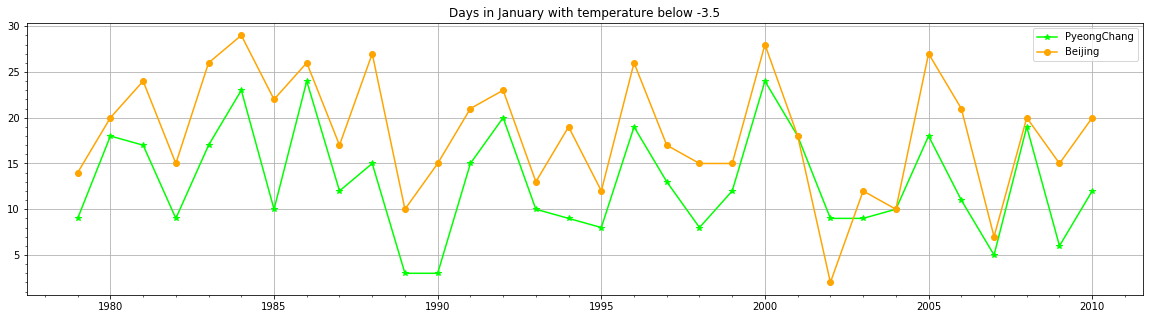

In [16]:
i_jan = np.where(dd1.Temp_celsius['time1.month'].values == 2)
temp_jan1 = dd1.Temp_celsius[i_jan].resample('1D', dim='time1', how='mean').mean(axis=(1,2,3))
temp_jan2 = dd2.Temp_celsius[i_jan].resample('1D', dim='time1', how='mean').mean(axis=(1,2,3))

make_comparison_plot(temp_jan1[np.where(temp_jan1.values < -3.5)].groupby('time1.year').count(),area_name1,temp_jan2[np.where(temp_jan2.values < -3.5)].groupby('time1.year').count(),area_name2,'Days in January with temperature below -3.5')

In conclusion, after analyzing the snow depth in February and average temperature in January in PyeongChang and Beijing during the recent decades, we discovered that even though both of the locations fail to meet the natural snow conditions, they at least have quite constantly cold air to enable artificial snowmaking. Hence we believe that neither of the Winter Olympic Games locations will fail to meet the necessary snow requirements.